In [5]:
import numpy as np 
import pandas as pd 
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime, date 
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.arima_model import ARIMA
from pmdarima import auto_arima


# 1. Reading the data collection 

In [6]:
total_data = pd.read_csv("../data/raw/Aquifer_Petrignano.csv")
total_data.head(5)

,Date,Rainfall_Bastia_Umbra,Depth_to_Groundwater_P24,Depth_to_Groundwater_P25,Temperature_Bastia_Umbra,Temperature_Petrignano,Volume_C10_Petrignano,Hydrometry_Fiume_Chiascio_Petrignano
0,14/03/2006,NaN,-22.48,-22.18,NaN,NaN,NaN,NaN
1,15/03/2006,NaN,-22.38,-22.14,NaN,NaN,NaN,NaN
2,16/03/2006,NaN,-22.25,-22.04,NaN,NaN,NaN,NaN
3,17/03/2006,NaN,-22.38,-22.04,NaN,NaN,NaN,NaN
4,18/03/2006,NaN,-22.60,-22.04,NaN,NaN,NaN,NaN


# 2. Cleaning the dataframe

In [7]:
#Remove columns with Nan values and others we won't use
total_data = total_data[total_data.Rainfall_Bastia_Umbra.notna()].reset_index(drop=True)
total_data = total_data.drop(['Depth_to_Groundwater_P24', 'Temperature_Petrignano'], axis=1)

In [8]:
#Lowering the names of the columns
total_data.columns = ['date', 'rainfall', 'depth_to_groundwater', 'temperature', 'drainage_volume', 'river_hydrometry']
target = ['depth_to_groundwater']
values = [value for value in total_data.columns if value not in target]
total_data.head(5)

,date,rainfall,depth_to_groundwater,temperature,drainage_volume,river_hydrometry
0,01/01/2009,0.0,-31.14,5.2,-24530.688,2.4
1,02/01/2009,0.0,-31.11,2.3,-28785.888,2.5
2,03/01/2009,0.0,-31.07,4.4,-25766.208,2.4
3,04/01/2009,0.0,-31.05,0.8,-27919.296,2.4
4,05/01/2009,0.0,-31.01,-1.9,-29854.656,2.3


In [9]:
#Since we are working with a time series, we need to transfor the dataframe
total_data['date'] = pd.to_datetime(total_data['date'], format = '%d/%m/%Y')
new_data = total_data.set_index('date')
new_data.head(5)

,rainfall,depth_to_groundwater,temperature,drainage_volume,river_hydrometry
date,,,,,
2009-01-01,0.0,-31.14,5.2,-24530.688,2.4
2009-01-02,0.0,-31.11,2.3,-28785.888,2.5
2009-01-03,0.0,-31.07,4.4,-25766.208,2.4
2009-01-04,0.0,-31.05,0.8,-27919.296,2.4
2009-01-05,0.0,-31.01,-1.9,-29854.656,2.3


# 3. Visualization of the information

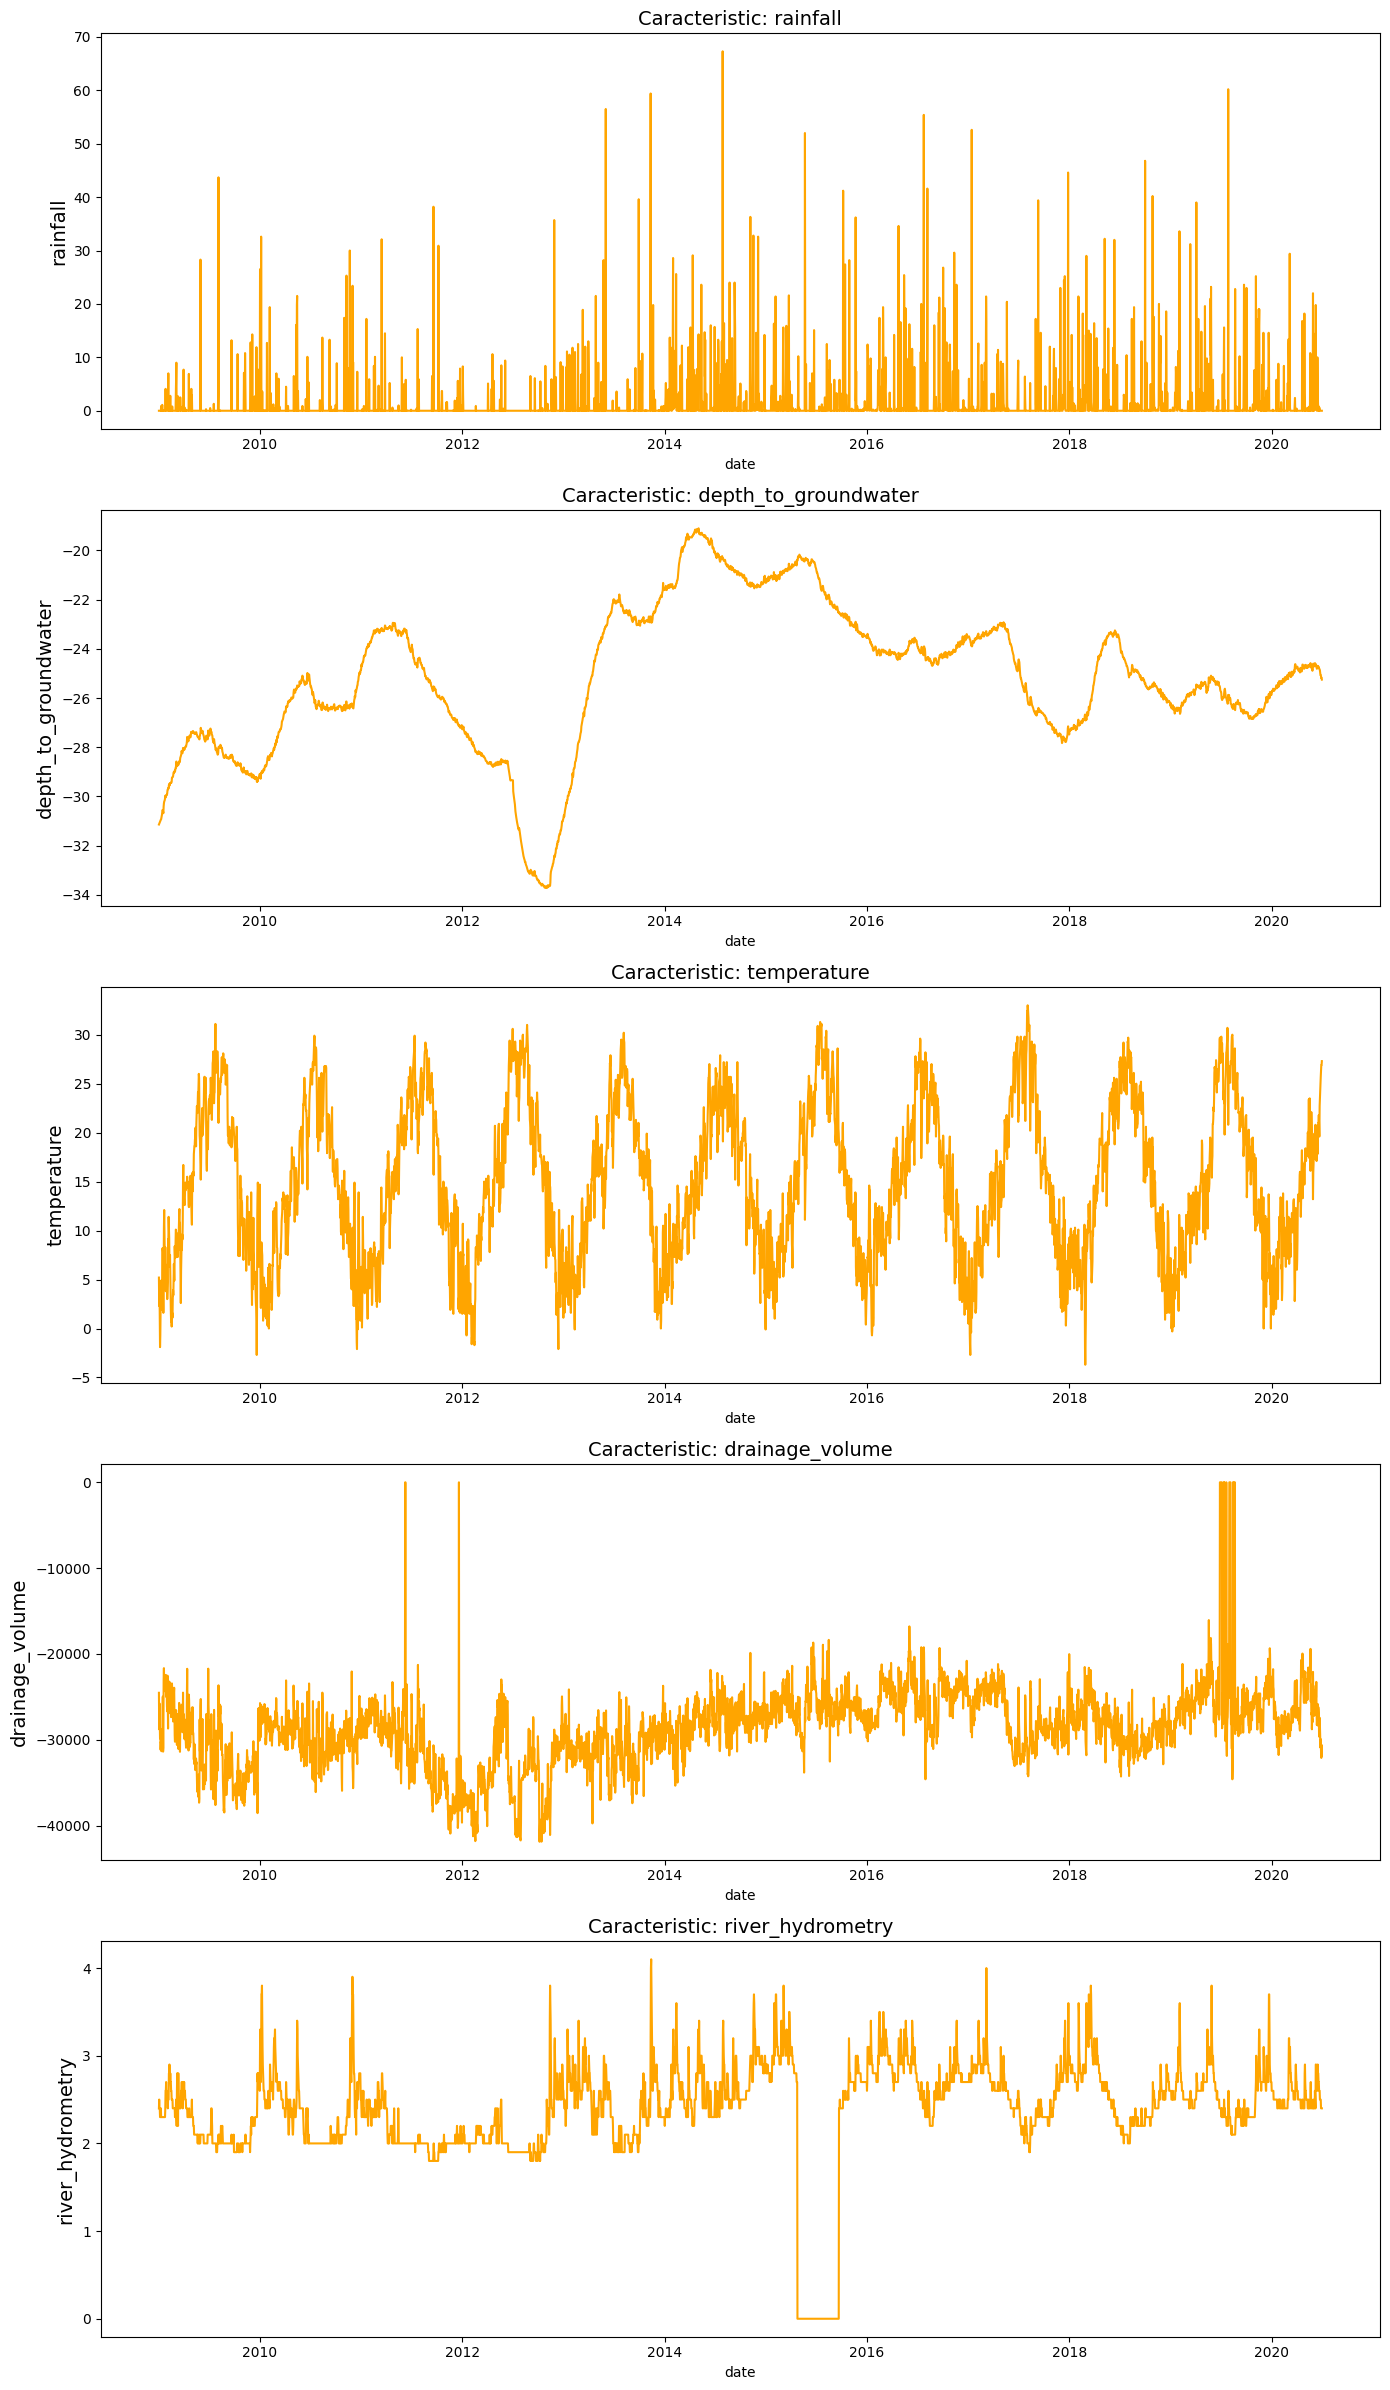

In [14]:
fig, ax = plt.subplots(5, 1, figsize = (14, 24))

for i, column in enumerate(total_data.drop('date', axis=1).columns):
    sns.lineplot(x=total_data['date'], y=total_data[column].fillna(method='ffill'), ax=ax[i], color='orange')
    ax[i].set_title('Caracteristic: {}'.format(column), fontsize=14)
    ax[i].set_ylabel(ylabel=column, fontsize=14)

plt.tight_layout()
plt.show()

# 4. Processing the data

In [ ]:
total_data = total_data.sort_values(by='date')
total_data['delta'] = total_data['date'] - total_data['date'].shift(1)
total_data[['date', 'delta']].head()

,date,delta
0,2009-01-01,NaT
1,2009-01-02,1 days
2,2009-01-03,1 days
3,2009-01-04,1 days
4,2009-01-05,1 days


In [ ]:
total_data['delta'].sum(), total_data['delta'].count()

(Timedelta('4198 days 00:00:00'), 4198)

# 4.1 Treating the Null values 

In [ ]:
total_data = total_data.drop('delta', axis=1)
total_data.isna().sum()

date                     0
rainfall                 0
depth_to_groundwater    27
temperature              0
drainage_volume          1
river_hydrometry         0
dtype: int64

(14245.0, 18443.0)

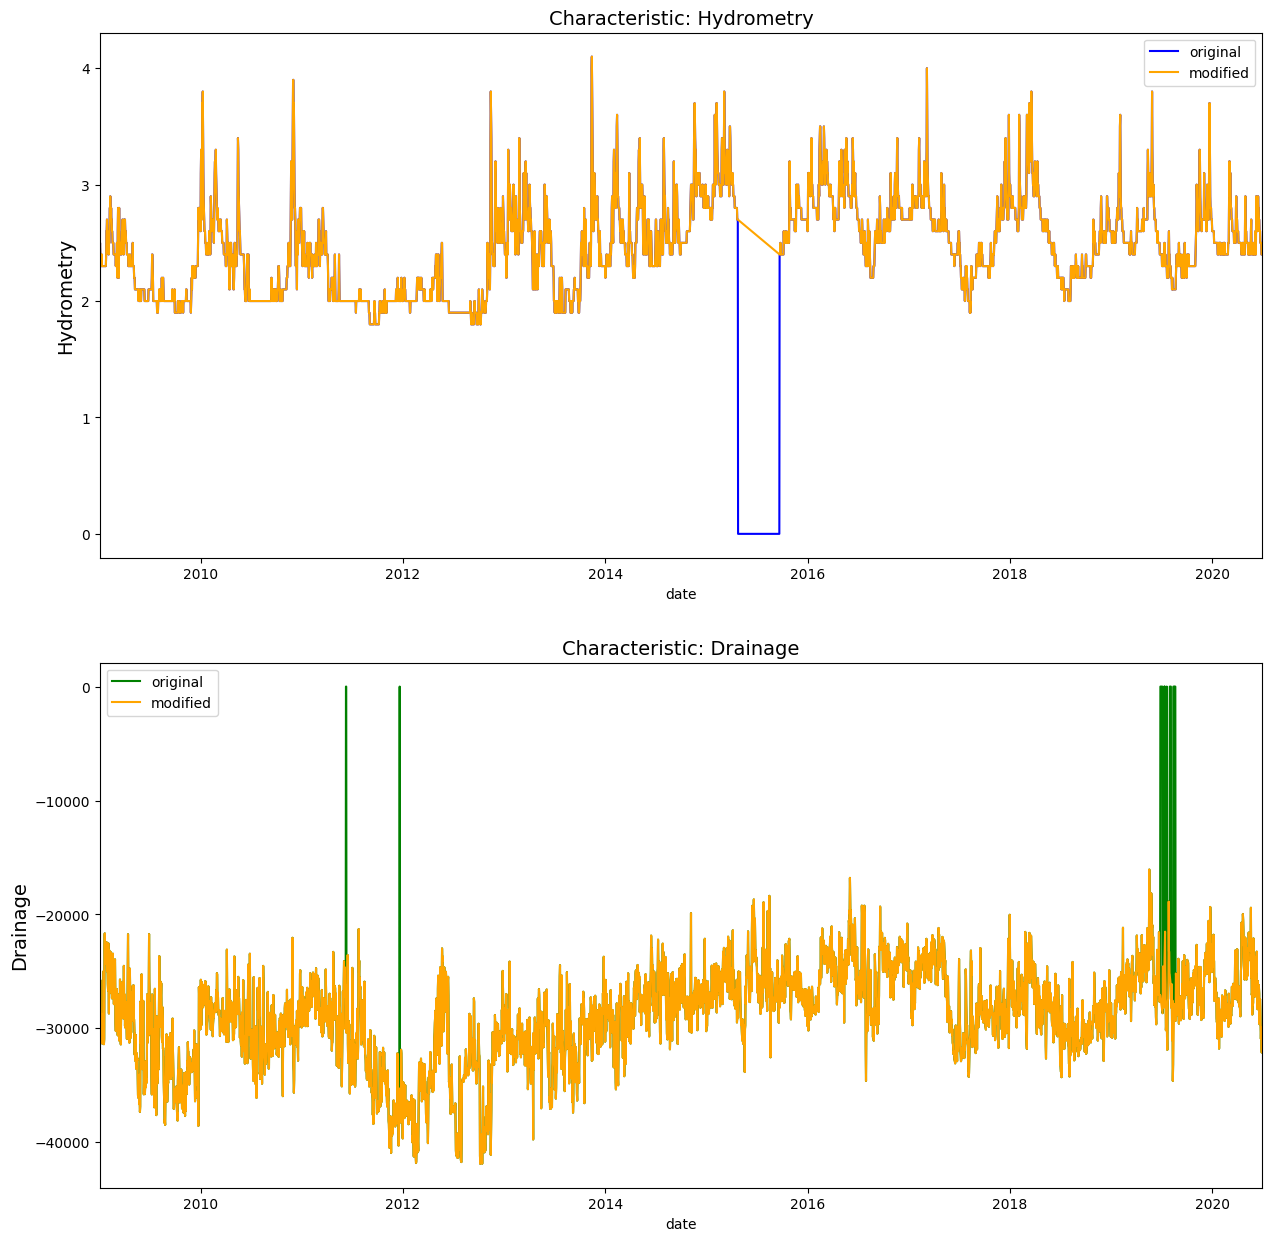

In [ ]:
f, ax = plt.subplots(2, 1, figsize=(15, 15))

pre_hydrometry = total_data['river_hydrometry'].copy()
total_data['river_hydrometry'] = total_data['river_hydrometry'].replace(0, np.nan)

sns.lineplot(x=total_data['date'], y=pre_hydrometry, ax=ax[0], color='blue', label='original')
sns.lineplot(x=total_data['date'], y=total_data['river_hydrometry'].fillna(np.inf), ax=ax[0], color='orange', label='modified')
ax[0].set_title('Characteristic: Hydrometry', fontsize=14)
ax[0].set_ylabel(ylabel='Hydrometry', fontsize=14)
ax[0].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])

pre_drainage = total_data['drainage_volume'].copy()
total_data['drainage_volume'] = total_data['drainage_volume'].replace(0, np.nan)

sns.lineplot(x=total_data['date'], y=pre_drainage, ax=ax[1], color='green', label='original')
sns.lineplot(x=total_data['date'], y=total_data['drainage_volume'].fillna(np.inf), ax=ax[1], color='orange', label='modified')
ax[1].set_title('Characteristic: Drainage', fontsize=14)
ax[1].set_ylabel(ylabel='Drainage', fontsize=14)
ax[1].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])

In [ ]:
#For the missing values, we'll interpolate them
total_data['drainage_volume'] = total_data['drainage_volume'].interpolate()
total_data['river_hydrometry'] = total_data['river_hydrometry'].interpolate()
total_data['depth_to_groundwater'] = total_data['depth_to_groundwater'].interpolate()

# 4.2 Decreasing reshampling

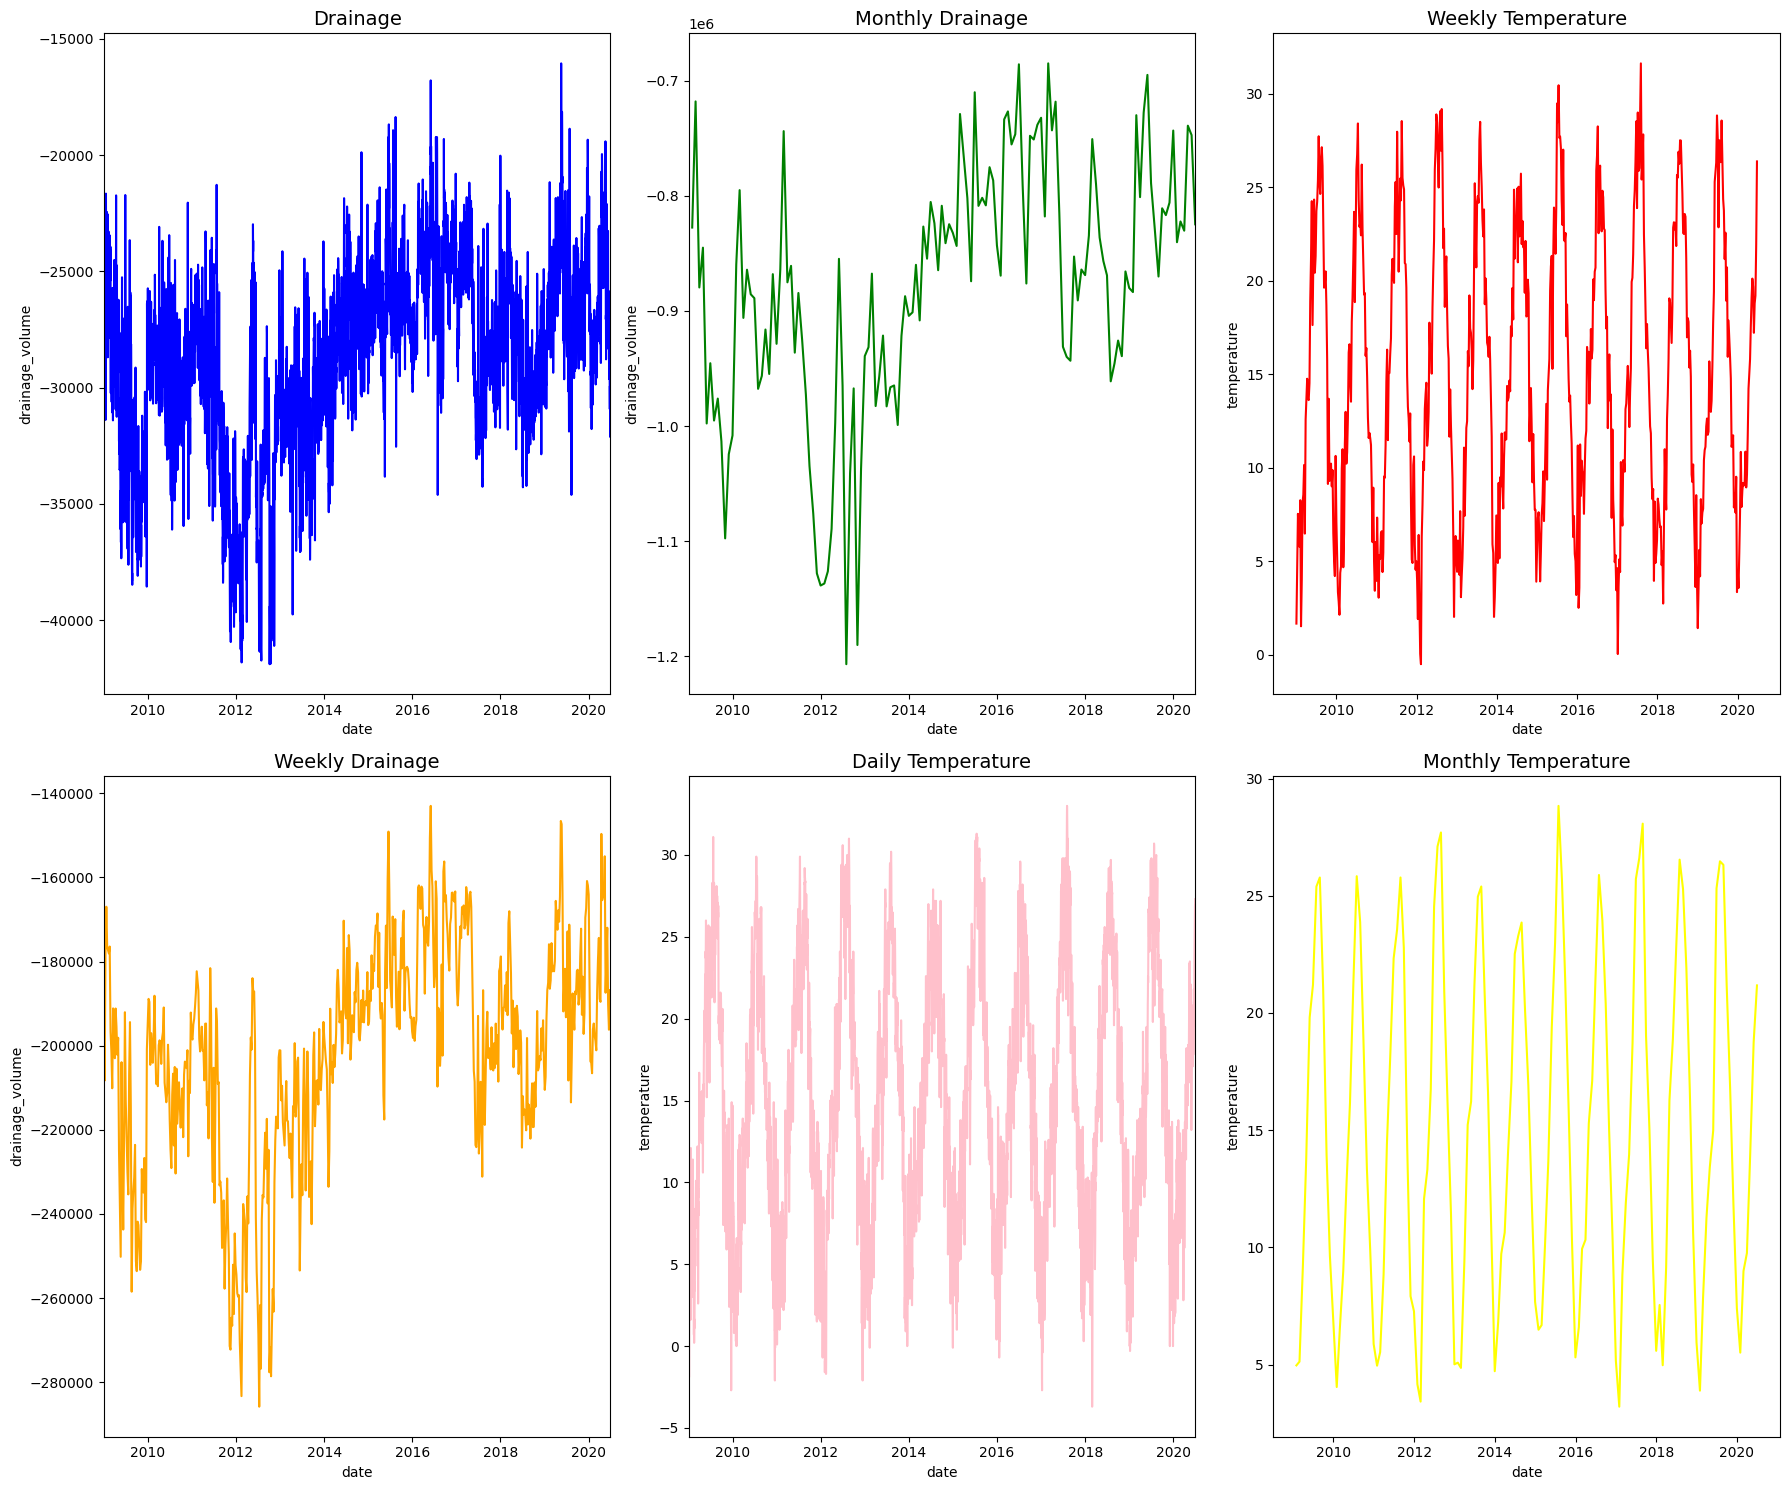

In [ ]:
#By doing this, we could get extra information from the data.
fig, ax = plt.subplots(2, 3, figsize=(18, 15)) 

# First Column: Drainage Volume
sns.lineplot(x='date', y='drainage_volume', data=total_data, color='blue', ax=ax[0, 0])
ax[0, 0].set_title('Drainage', fontsize=14)

# Weekly Drainage
resampled_weekly = total_data[['date', 'drainage_volume']].resample('7D', on='date').sum().reset_index()
sns.lineplot(x='date', y='drainage_volume', data=resampled_weekly, color='orange', ax=ax[1, 0])
ax[1, 0].set_title('Weekly Drainage', fontsize=14)

# Monthly Drainage
resampled_monthly = total_data[['date', 'drainage_volume']].resample('M', on='date').sum().reset_index()
sns.lineplot(x='date', y='drainage_volume', data=resampled_monthly, color='green', ax=ax[0, 1])  # Changed to fit within the grid
ax[0, 1].set_title('Monthly Drainage', fontsize=14)

# Adjust date range for the first column
for i in range(2):  # Loop over the first column (ax[0, 0] and ax[1, 0])
    ax[i, 0].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])

# Second Column: Temperature
sns.lineplot(x='date', y='temperature', data=total_data, color='pink', ax=ax[1, 1])  # Corrected placement
ax[1, 1].set_title('Daily Temperature', fontsize=14)

# Weekly Temperature
resampled_temp_weekly = total_data[['date', 'temperature']].resample('7D', on='date').mean().reset_index()
sns.lineplot(x='date', y='temperature', data=resampled_temp_weekly, color='red', ax=ax[0, 2])  # Adjusted grid placement
ax[0, 2].set_title('Weekly Temperature', fontsize=14)

# Monthly Temperature
resampled_temp_monthly = total_data[['date', 'temperature']].resample('M', on='date').mean().reset_index()
sns.lineplot(x='date', y='temperature', data=resampled_temp_monthly, color='yellow', ax=ax[1, 2])  # Adjusted grid placement
ax[1, 2].set_title('Monthly Temperature', fontsize=14)

# Adjust date range for the second column
for i in range(2):  # Loop over the second column (ax[0, 1] and ax[1, 1])
    ax[i, 1].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])

plt.tight_layout()
plt.show()

In [ ]:
downsample = total_data[['date',
                 'depth_to_groundwater', 
                 'temperature',
                 'drainage_volume', 
                 'river_hydrometry',
                 'rainfall'
                ]].resample('7D', on='date').mean().reset_index(drop=False)

total_data = downsample.copy()

# 4.3 Stationality

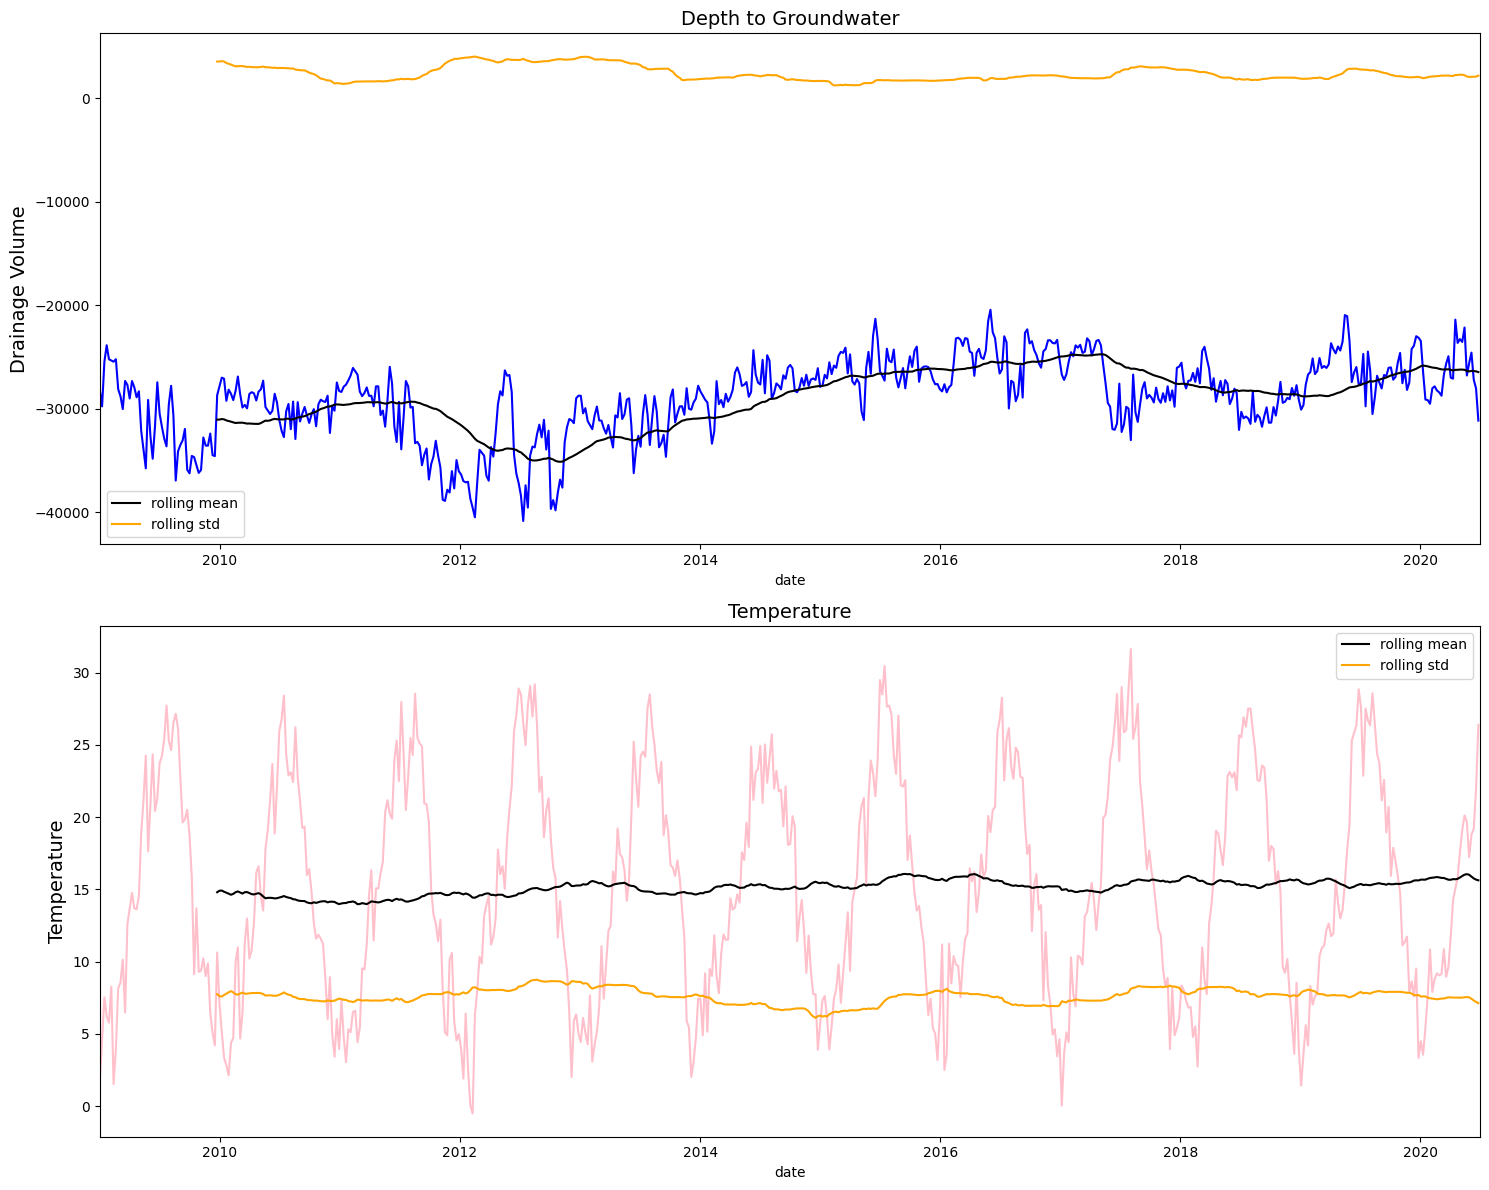

In [ ]:
rolling_window = 52
f, ax = plt.subplots(2, 1, figsize=(15, 12))

sns.lineplot(x=total_data['date'], y=total_data['drainage_volume'], ax=ax[0], color='blue')
sns.lineplot(x=total_data['date'], y=total_data['drainage_volume'].rolling(rolling_window).mean(), ax=ax[0], color='black', label='rolling mean')
sns.lineplot(x=total_data['date'], y=total_data['drainage_volume'].rolling(rolling_window).std(), ax=ax[0], color='orange', label='rolling std')
ax[0].set_title('Depth to Groundwater', fontsize=14)
ax[0].set_ylabel(ylabel='Drainage Volume', fontsize=14)
ax[0].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])

sns.lineplot(x=total_data['date'], y=total_data['temperature'], ax=ax[1], color='pink')
sns.lineplot(x=total_data['date'], y=total_data['temperature'].rolling(rolling_window).mean(), ax=ax[1], color='black', label='rolling mean')
sns.lineplot(x=total_data['date'], y=total_data['temperature'].rolling(rolling_window).std(), ax=ax[1], color='orange', label='rolling std')
ax[1].set_title('Temperature', fontsize=14)
ax[1].set_ylabel(ylabel='Temperature', fontsize=14)
ax[1].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])

plt.tight_layout()
plt.show()

# 4.3.1 Dickey-Fuller 

In [ ]:
def test_stationarity(timeseries):
    print("Dickey-Fuller test results:")
    dftest = adfuller(timeseries, autolag = "AIC")
    dfoutput = pd.Series(dftest[0:4], index = ["Test Statistic", "p-value", "#Lags Used", "Number of Observations Used"])
    for key,value in dftest[4].items():
        dfoutput["Critical Value (%s)"%key] = value
    return dfoutput

test_stationarity(total_data['depth_to_groundwater'])

Dickey-Fuller test results:


Test Statistic                  -2.880202
p-value                          0.047699
#Lags Used                       7.000000
Number of Observations Used    592.000000
Critical Value (1%)             -3.441444
Critical Value (5%)             -2.866435
Critical Value (10%)            -2.569377
dtype: float64

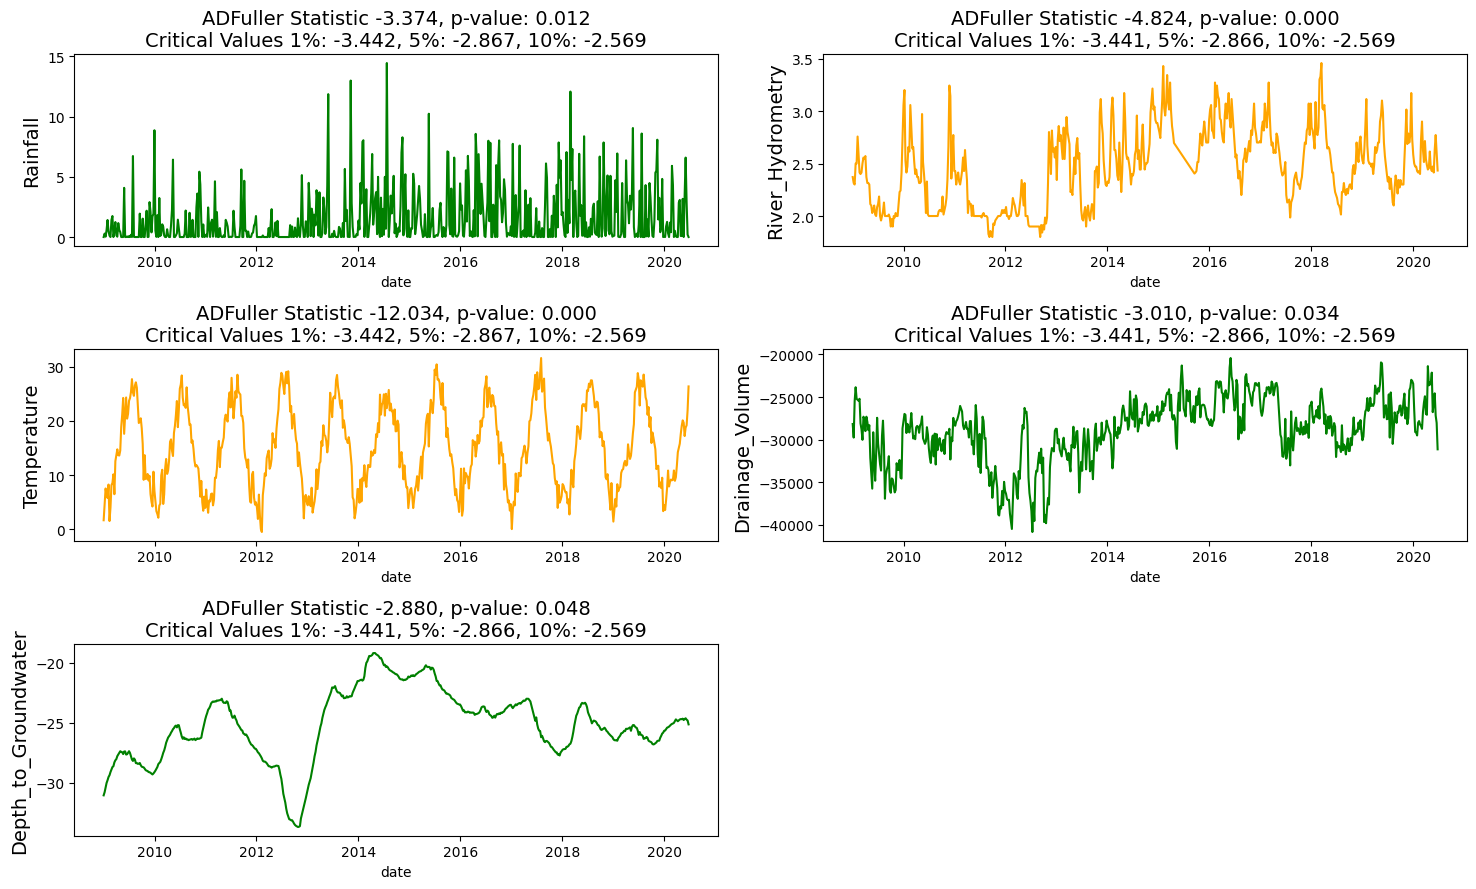

In [ ]:
f, ax = plt.subplots(nrows=3, ncols=2, figsize=(15, 9))

def visualize_adfuller(series, title, ax):
    result = adfuller(series)
    significance_level = 0.05
    adf_stat = result[0]
    p_val = result[1]
    crit_val_1 = result[4]['1%']
    crit_val_5 = result[4]['5%']
    crit_val_10 = result[4]['10%']

    if (p_val < significance_level) & ((adf_stat < crit_val_1)):
        linecolor = 'orange' 
    elif (p_val < significance_level) & (adf_stat < crit_val_5):
        linecolor = 'green'
    elif (p_val < significance_level) & (adf_stat < crit_val_10):
        linecolor = 'blue'
    else:
        linecolor = 'pink'
    sns.lineplot(x=total_data['date'], y=series, ax=ax, color=linecolor)
    ax.set_title(f'ADFuller Statistic {adf_stat:0.3f}, p-value: {p_val:0.3f}\nCritical Values 1%: {crit_val_1:0.3f}, 5%: {crit_val_5:0.3f}, 10%: {crit_val_10:0.3f}', fontsize=14)
    ax.set_ylabel(ylabel=title, fontsize=14)

visualize_adfuller(total_data['rainfall'].values, 'Rainfall', ax[0, 0])
visualize_adfuller(total_data['temperature'].values, 'Temperature', ax[1, 0])
visualize_adfuller(total_data['river_hydrometry'].values, 'River_Hydrometry', ax[0, 1])
visualize_adfuller(total_data['drainage_volume'].values, 'Drainage_Volume', ax[1, 1])
visualize_adfuller(total_data['depth_to_groundwater'].values, 'Depth_to_Groundwater', ax[2, 0])

f.delaxes(ax[2, 1])
plt.tight_layout()
plt.show()

# 4.3.2 Transforming

<Axes: xlabel='depth_to_groundwater_log', ylabel='Density'>

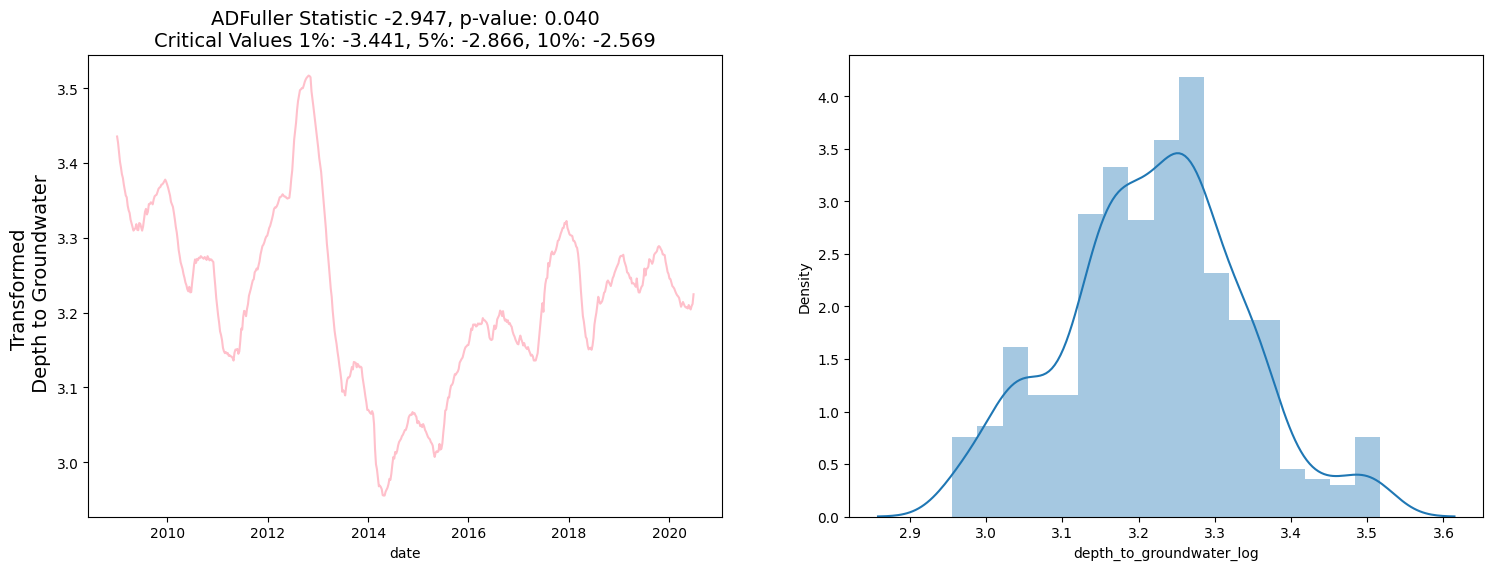

In [ ]:
total_data['depth_to_groundwater_log'] = np.log(abs(total_data['depth_to_groundwater']))

f, ax = plt.subplots(1, 2, figsize=(18, 6))
visualize_adfuller(total_data['depth_to_groundwater_log'], 'Transformed \n Depth to Groundwater', ax[0])

sns.distplot(total_data['depth_to_groundwater_log'], ax=ax[1])

# 4.3.3 Differencing

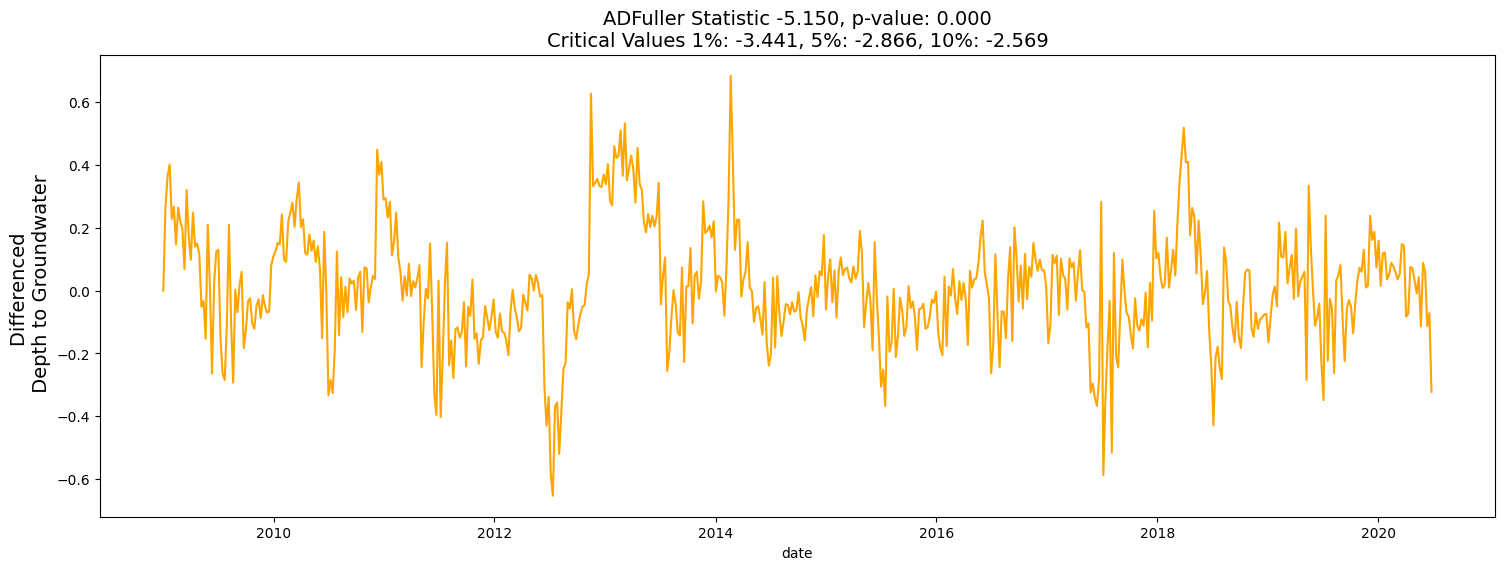

In [ ]:
diff = np.diff(total_data['depth_to_groundwater'])
total_data['depth_to_groundwater_diff_1'] = np.append([0], diff)

f, ax = plt.subplots(1, 1, figsize=(18, 6))
visualize_adfuller(total_data['depth_to_groundwater_diff_1'], 'Differenced \n Depth to Groundwater', ax)

# 5. Feature engineering

In [ ]:
total_data['year'] = pd.DatetimeIndex(total_data['date']).year
total_data['month'] = pd.DatetimeIndex(total_data['date']).month
total_data['day'] = pd.DatetimeIndex(total_data['date']).day
total_data['day_of_year'] = pd.DatetimeIndex(total_data['date']).dayofyear
total_data['week_of_year'] = pd.DatetimeIndex(total_data['date']).isocalendar().week
total_data['quarter'] = pd.DatetimeIndex(total_data['date']).quarter
total_data['season'] = total_data['month'] % 12 // 3 + 1

total_data[['date', 'year', 'month', 'day', 'day_of_year', 'week_of_year', 'quarter', 'season']].head()

,date,year,month,day,day_of_year,week_of_year,quarter,season
0,2009-01-01,2009,1,1,1,<NA>,1,1
1,2009-01-08,2009,1,8,8,<NA>,1,1
2,2009-01-15,2009,1,15,15,<NA>,1,1
3,2009-01-22,2009,1,22,22,<NA>,1,1
4,2009-01-29,2009,1,29,29,<NA>,1,1


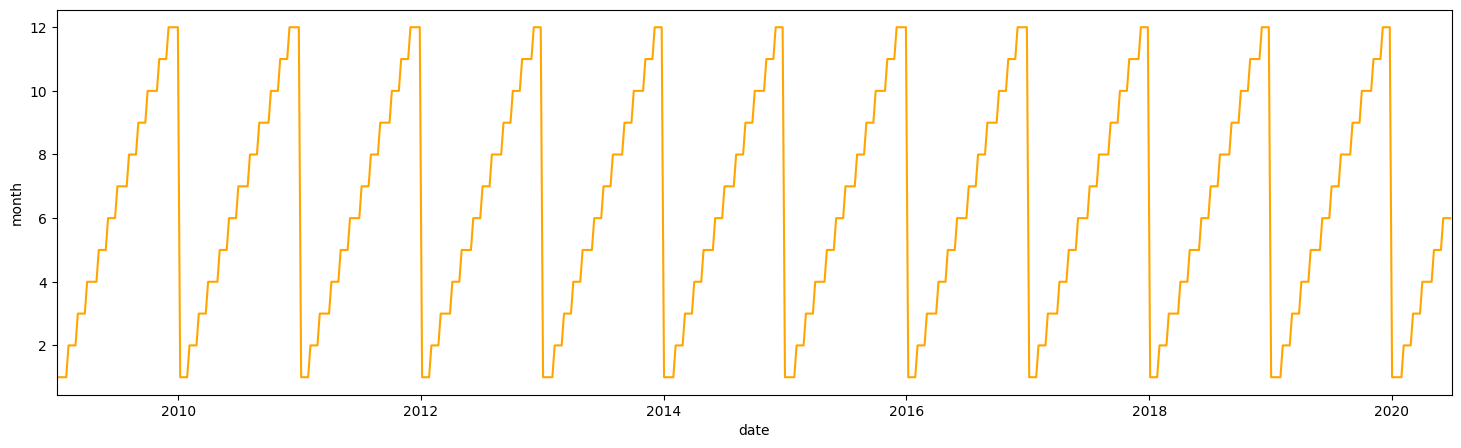

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(18, 5))

sns.lineplot(x=total_data['date'], y=total_data['month'], color='orange')
ax.set_xlim([date(2009, 1, 1), date(2020, 6, 30)])
plt.show()

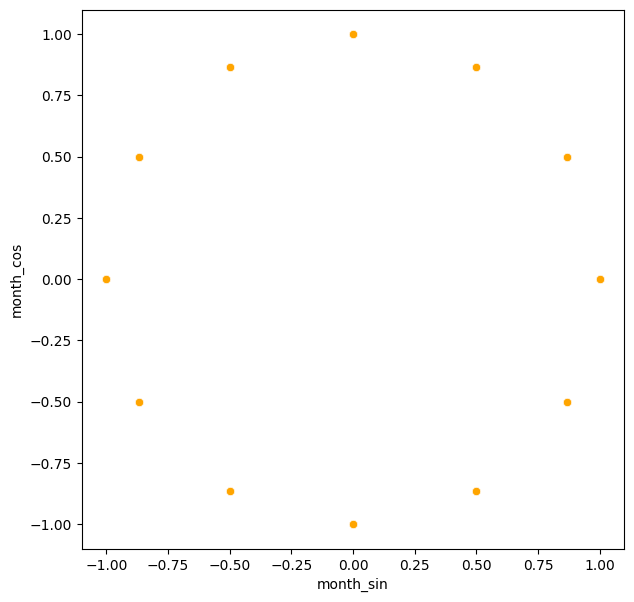

In [ ]:
month_in_year = 12
total_data['month_sin'] = np.sin(2*np.pi*total_data['month']/month_in_year)
total_data['month_cos'] = np.cos(2*np.pi*total_data['month']/month_in_year)

fig, ax = plt.subplots(1, 1, figsize=(7, 7))

sns.scatterplot(x=total_data.month_sin, y=total_data.month_cos, color='orange')
plt.show()

In [ ]:
main_columns =  [
    'rainfall', 'temperature', 'drainage_volume', 
    'river_hydrometry', 'depth_to_groundwater'
]

for column in main_columns:
    decomp = seasonal_decompose(total_data[column], period=52, model='additive', extrapolate_trend='freq')
    total_data[f"{column}_trend"] = decomp.trend
    total_data[f"{column}_seasonal"] = decomp.seasonal

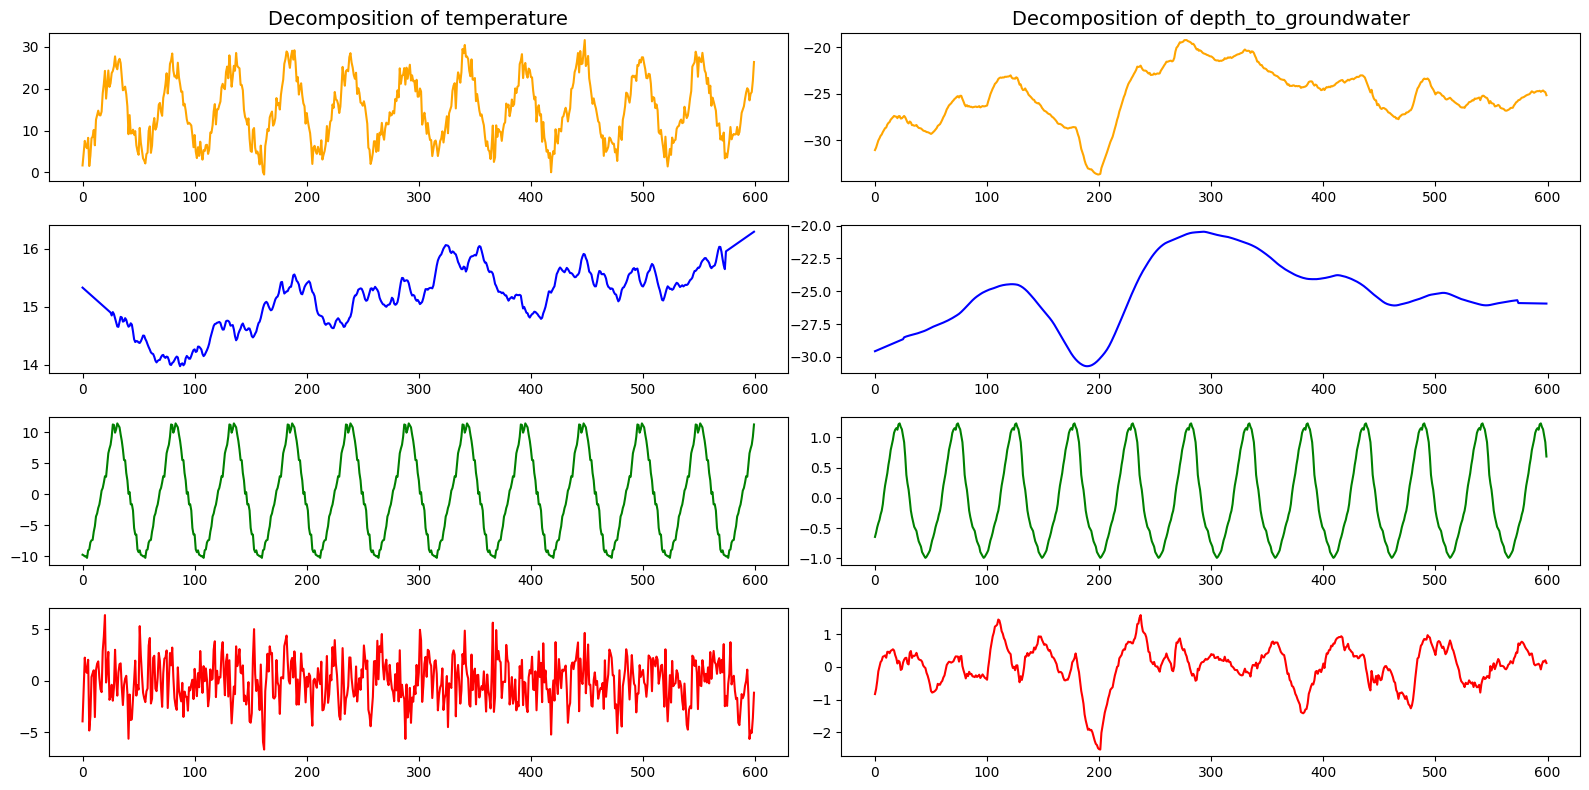

In [ ]:
fig, ax = plt.subplots(4, 2, figsize=(16, 8))

for i, column in enumerate(['temperature', 'depth_to_groundwater']):
    ts_data = total_data[column].dropna()

    res = seasonal_decompose(ts_data, period=52, model='additive', extrapolate_trend='freq')

    ax[0, i].set_title(f'Decomposition of {column}', fontsize=14)
    res.observed.plot(ax=ax[0, i], legend=False, color='orange')
    res.trend.plot(ax=ax[1, i], legend=False, color='blue')
    res.seasonal.plot(ax=ax[2, i], legend=False, color='green')
    res.resid.plot(ax=ax[3, i], legend=False, color='red')

plt.tight_layout()
plt.show()

# 5.1 Lag - function shift()

In [ ]:
weeks_in_month = 4

for column in main_columns:
    total_data[f'{column}_seasonal_shift_b_2m'] = total_data[f'{column}_seasonal'].shift(-2 * weeks_in_month)
    total_data[f'{column}_seasonal_shift_b_1m'] = total_data[f'{column}_seasonal'].shift(-1 * weeks_in_month)
    total_data[f'{column}_seasonal_shift_1m'] = total_data[f'{column}_seasonal'].shift(1 * weeks_in_month)
    total_data[f'{column}_seasonal_shift_2m'] = total_data[f'{column}_seasonal'].shift(2 * weeks_in_month)
    total_data[f'{column}_seasonal_shift_3m'] = total_data[f'{column}_seasonal'].shift(3 * weeks_in_month)

# 6. EDA analysis

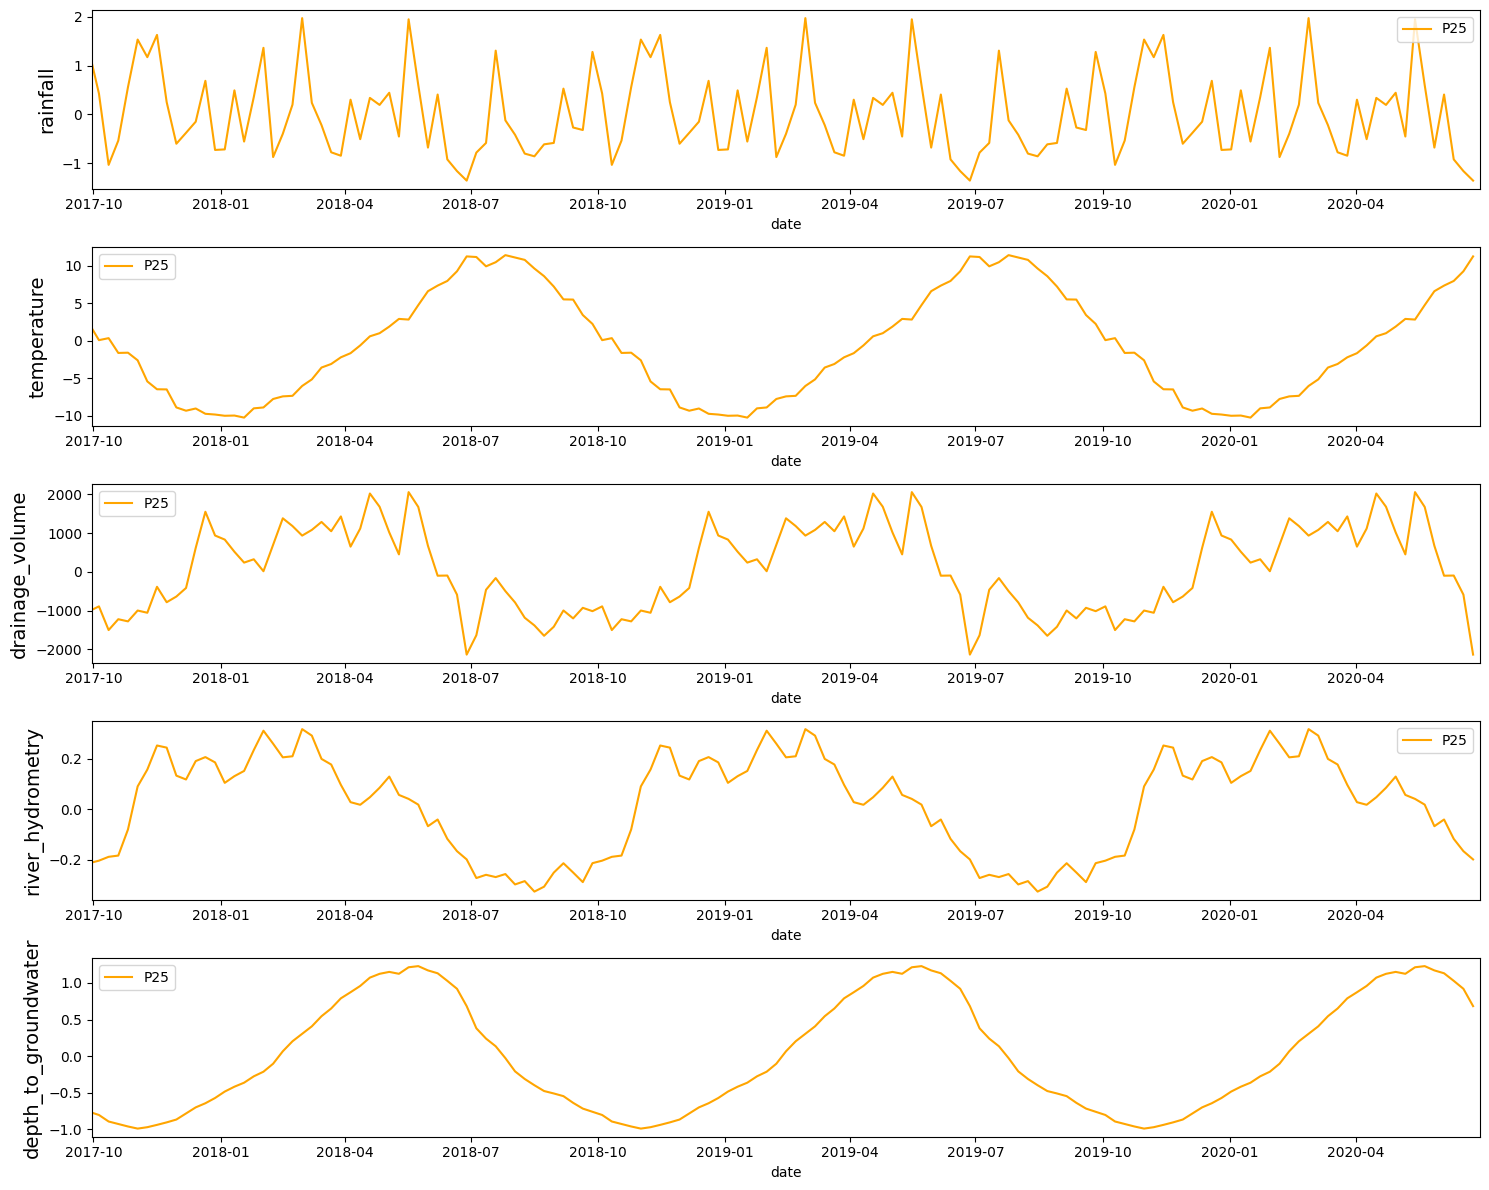

In [ ]:
fig, ax = plt.subplots(5, 1, figsize=(15, 12))
f.suptitle('Seasonal Components of Features', fontsize=16)

for i, column in enumerate(main_columns):
    sns.lineplot(x=total_data['date'], y=total_data[column + '_seasonal'], ax=ax[i], color='orange', label='P25')
    ax[i].set_ylabel(ylabel=column, fontsize=14)
    ax[i].set_xlim([date(2017, 9, 30), date(2020, 6, 30)])
    
plt.tight_layout()
plt.show()

# 6.1 Correlation analysis

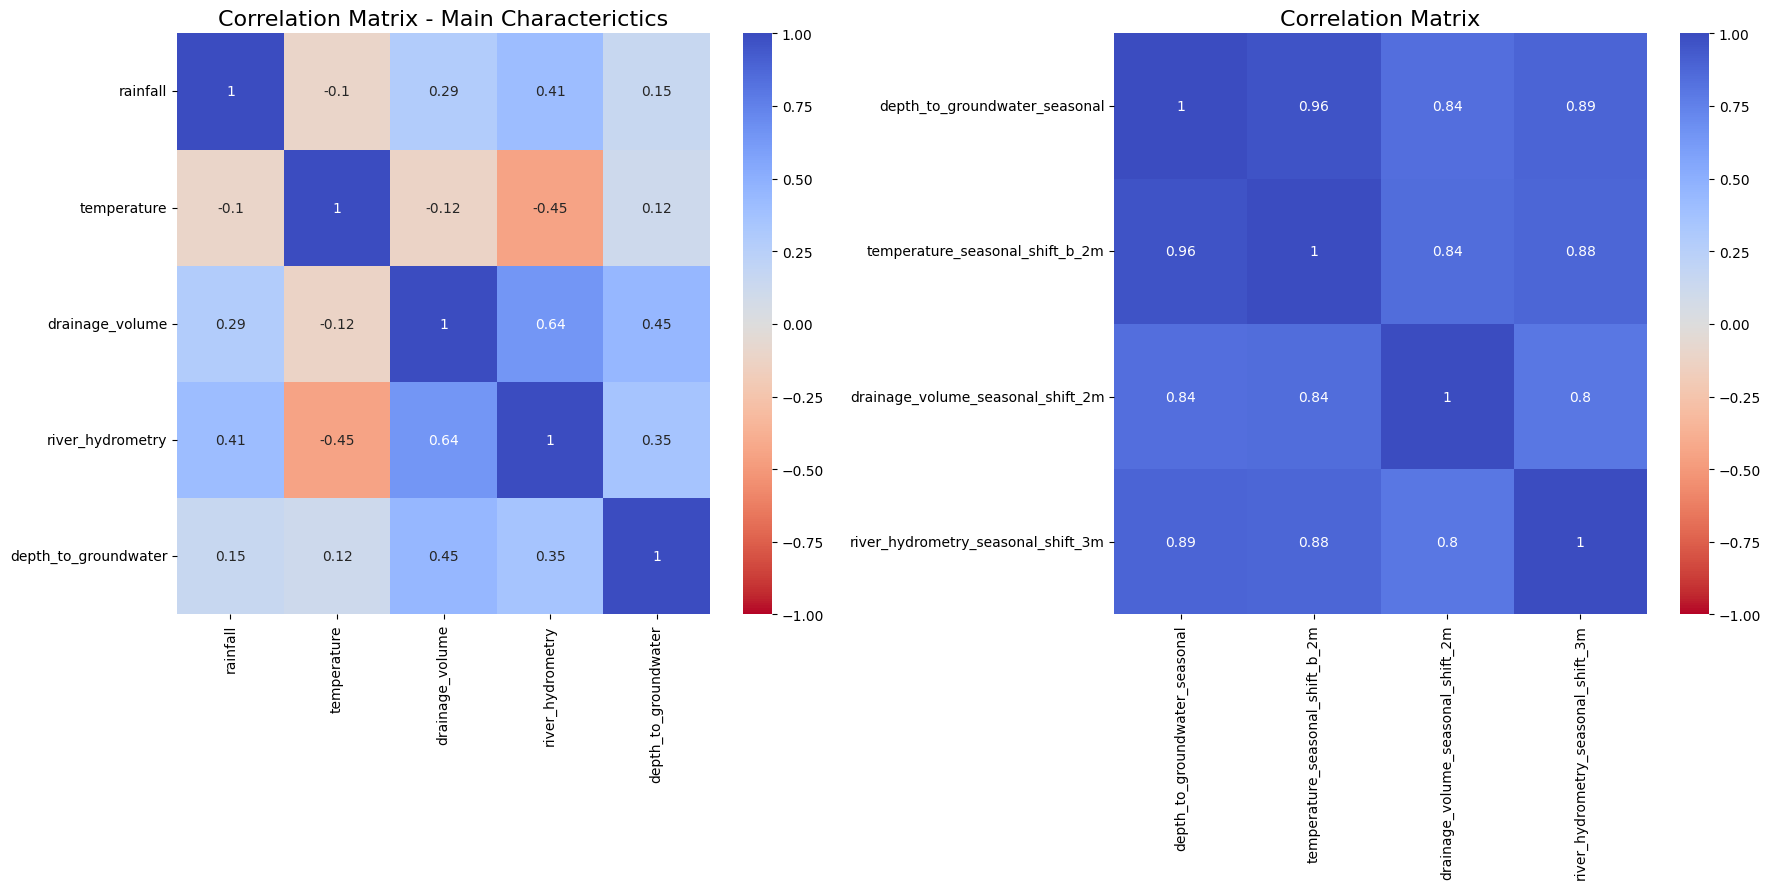

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(18, 9))

matrix = total_data[main_columns].corr()

sns.heatmap(matrix, annot=True, vmin=-1, vmax=1, cmap='coolwarm_r', ax=ax[0])
ax[0].set_title('Correlation Matrix - Main Characterictics', fontsize=16)

changed_cols = [
    'depth_to_groundwater_seasonal',         
    'temperature_seasonal_shift_b_2m',
    'drainage_volume_seasonal_shift_2m', 
    'river_hydrometry_seasonal_shift_3m'
]
matrix = total_data[changed_cols].corr()

sns.heatmap(matrix, annot=True, vmin=-1, vmax=1, cmap='coolwarm_r', ax=ax[1])
ax[1].set_title('Correlation Matrix', fontsize=16)


plt.tight_layout()
plt.show()

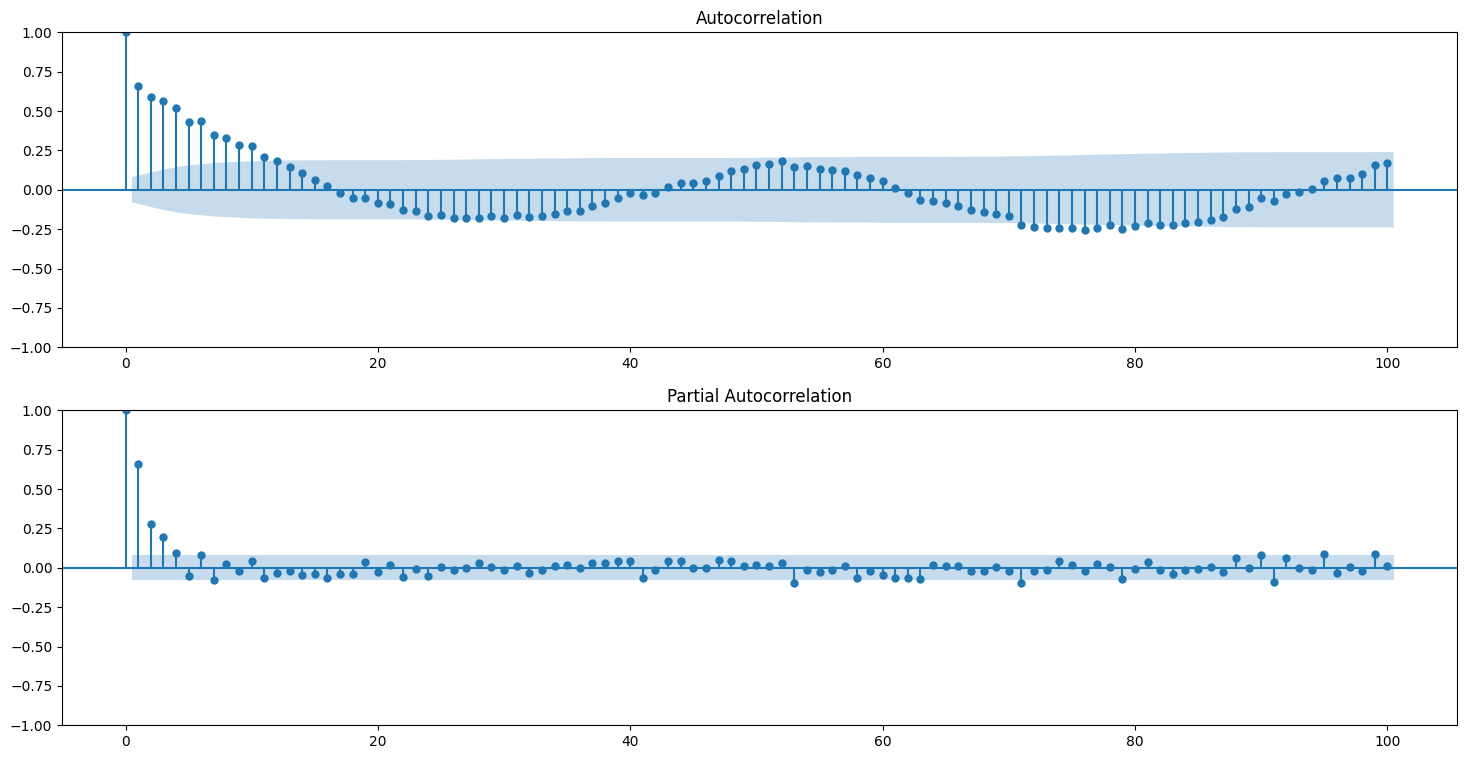

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(18, 9))

plot_acf(total_data['depth_to_groundwater_diff_1'], lags=100, ax=ax[0])
plot_pacf(total_data['depth_to_groundwater_diff_1'], lags=100, ax=ax[1])

plt.show()

# 7. Modeling - ARIMA

In [ ]:
n_spl = 3

X = total_data['date']
y = total_data['depth_to_groundwater']

folds = TimeSeriesSplit(n_splits=n_spl)

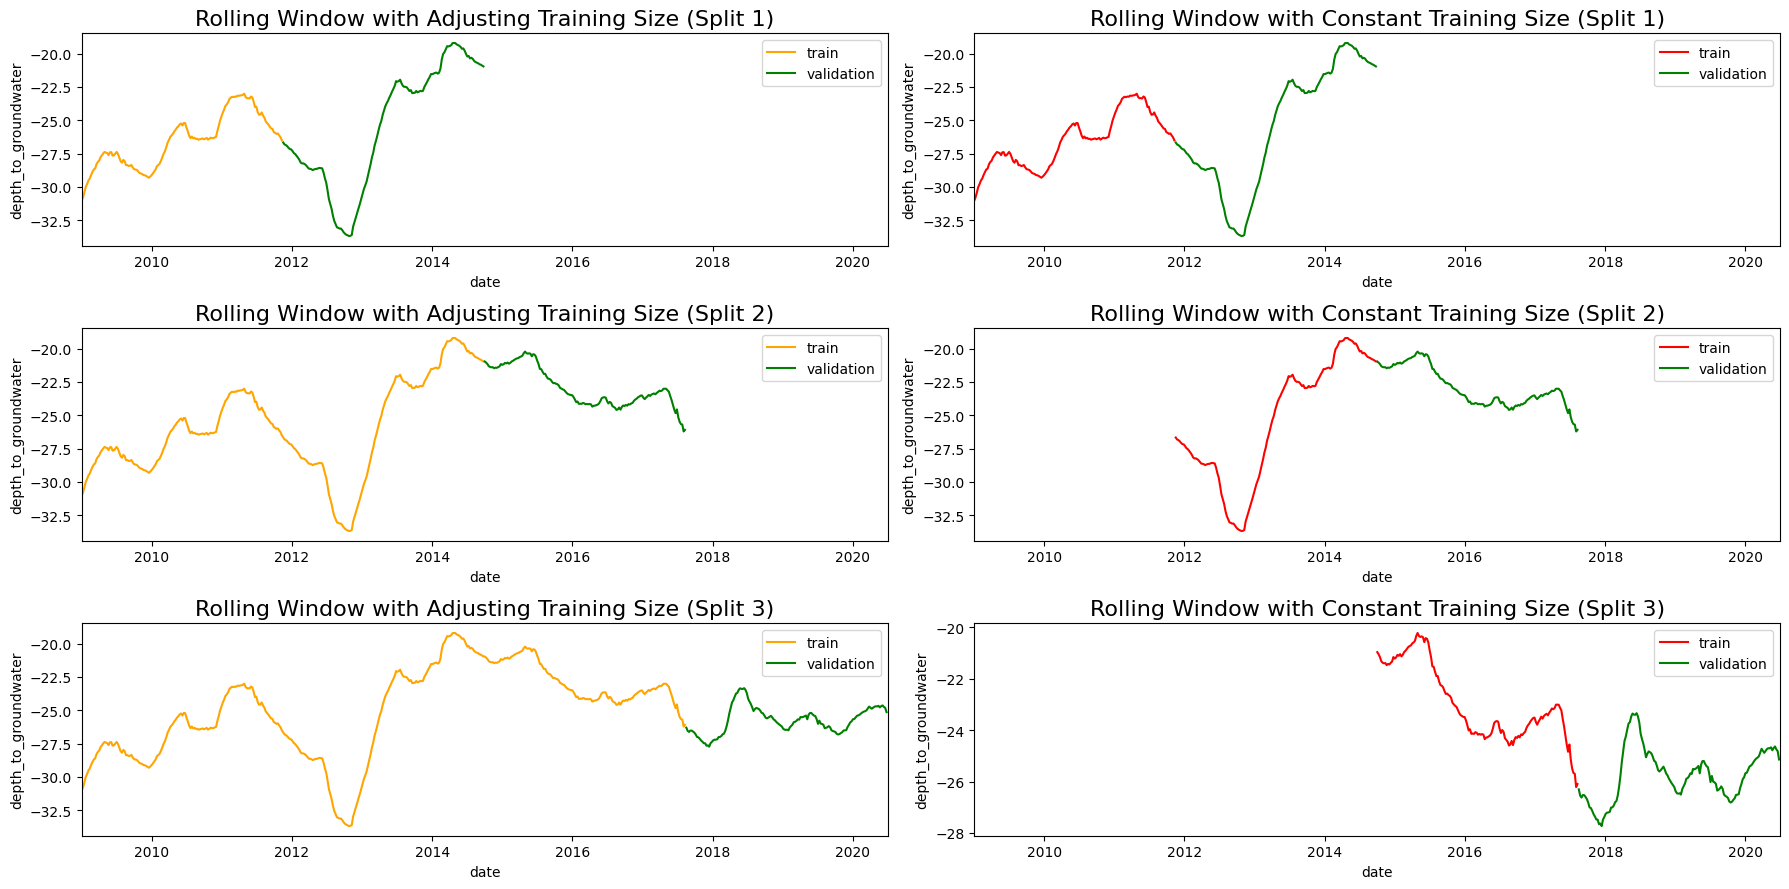

In [ ]:
fig, ax = plt.subplots(n_spl, 2, figsize=(18, 9))

for i, (train_index, valid_index) in enumerate(folds.split(X)):
    X_train, X_valid = X[train_index], X[valid_index]
    y_train, y_valid = y[train_index], y[valid_index]

    sns.lineplot(
        x=X_train, 
        y=y_train, 
        ax=ax[i,0], 
        color='orange', 
        label='train'
    )
    sns.lineplot(
        x=X_train[len(X_train) - len(X_valid):(len(X_train) - len(X_valid) + len(X_valid))], 
        y=y_train[len(X_train) - len(X_valid):(len(X_train) - len(X_valid) + len(X_valid))], 
        ax=ax[i,1], 
        color='red', 
        label='train'
    )

    for j in range(2):
        sns.lineplot(x= X_valid, y= y_valid, ax=ax[i, j], color='green', label='validation')
    ax[i, 0].set_title(f"Rolling Window with Adjusting Training Size (Split {i+1})", fontsize=16)
    ax[i, 1].set_title(f"Rolling Window with Constant Training Size (Split {i+1})", fontsize=16)

for i in range(n_spl):
    ax[i, 0].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])
    ax[i, 1].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])
    
plt.tight_layout()
plt.show()

In [ ]:
train_size = int(0.85 * len(total_data))
test_size = len(total_data) - train_size

univar = total_data[['date', 'depth_to_groundwater']].copy()
univar.columns = ['ds', 'y']

train = univar.iloc[:train_size, :]

x_train, y_train = pd.DataFrame(univar.iloc[:train_size, 0]), pd.DataFrame(univar.iloc[:train_size, 1])
x_valid, y_valid = pd.DataFrame(univar.iloc[train_size:, 0]), pd.DataFrame(univar.iloc[train_size:, 1])

print(len(train), len(x_valid))

510 90


In [ ]:
model = pm.auto_arima(y_train, start_p=1, start_q=1, test='adf', max_p=3, max_q=3, 
                      m=1, d=None, seasonal=False, start_P=0, D=0, trace=True, error_action='ignore',  
                      suppress_warnings=True, stepwise=True)

model

Performing stepwise search to minimize aic


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-631.136, Time=0.49 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-242.692, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-574.047, Time=0.17 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-427.347, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-243.054, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-629.209, Time=0.51 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-629.237, Time=0.78 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-492.779, Time=0.21 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-611.065, Time=0.20 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-628.351, Time=0.94 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-632.995, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-428.258, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-575.735, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-631.069, Time=0.23 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-631.097, Time=0.10 sec
 ARIMA(0,1

ARIMA(order=(1, 1, 1), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [ ]:
forecast = model.predict(60)
forecast

510   -25.687035
511   -25.802536
512   -25.908746
513   -26.006411
514   -26.096219
515   -26.178803
516   -26.254743
517   -26.324574
518   -26.388787
519   -26.447834
520   -26.502132
521   -26.552061
522   -26.597973
523   -26.640192
524   -26.679015
525   -26.714714
526   -26.747542
527   -26.777728
528   -26.805487
529   -26.831012
530   -26.854483
531   -26.876067
532   -26.895914
533   -26.914165
534   -26.930947
535   -26.946379
536   -26.960570
537   -26.973619
538   -26.985618
539   -26.996652
540   -27.006799
541   -27.016129
542   -27.024709
543   -27.032598
544   -27.039853
545   -27.046524
546   -27.052658
547   -27.058299
548   -27.063486
549   -27.068256
550   -27.072642
551   -27.076675
552   -27.080384
553   -27.083794
554   -27.086931
555   -27.089814
556   -27.092466
557   -27.094905
558   -27.097147
559   -27.099209
560   -27.101105
561   -27.102848
562   -27.104452
563   -27.105926
564   -27.107281
565   -27.108528
566   -27.109674
567   -27.110729
568   -27.1116

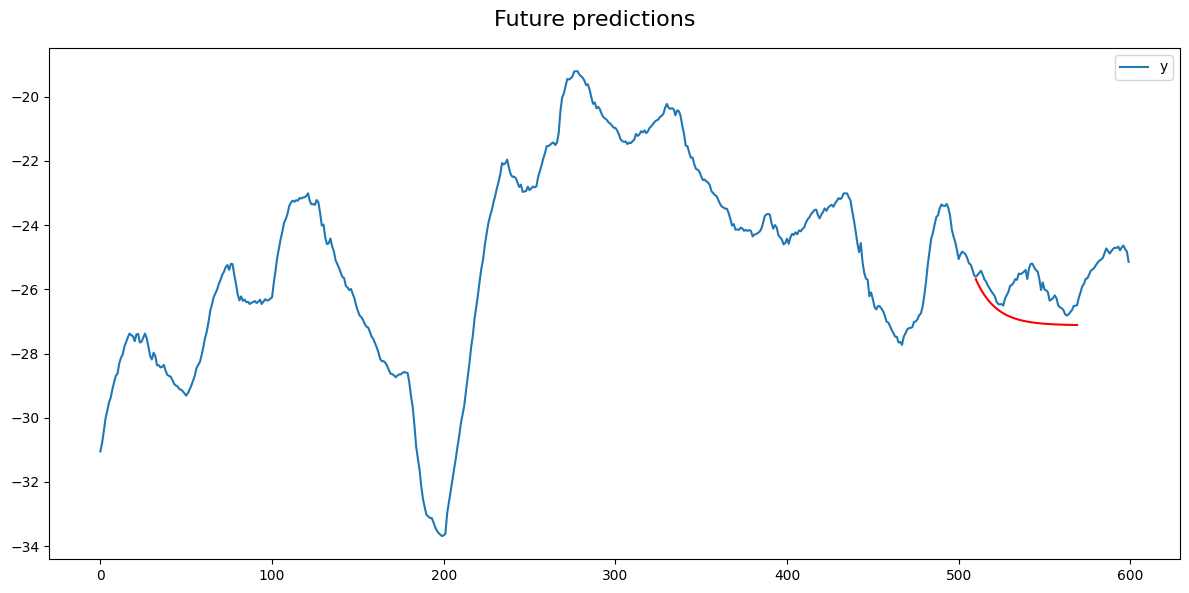

In [ ]:
fig, ax = plt.subplots(figsize = (12, 6))
fig.suptitle("Future predictions", fontsize=16)

sns.lineplot(data = univar, color = "blue")
sns.lineplot(data = forecast, color = "red")

plt.tight_layout()
plt.show()